In [3]:
from pathlib import Path
import json
from rouge import Rouge
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
# this notebook samples and formats articles for human annotation

In [6]:
pubmed_test = [json.loads(x) for x in Path("data/pubmed-release/test.txt").read_text().split("\n") if x]
pubmed_abstracts = ["\n".join(x['abstract_text']).replace("<S>", "").replace("</S>", "") for x in pubmed_test]

In [3]:
pubmed_test_pacsum_path = "results/exp8/pubmed_test_no_sections-pacsum_bert-cos-order-add_f=0.0_b=1.0_s=1.0/summaries.json"
pubmed_test_pacsum = json.loads(Path(pubmed_test_pacsum_path).read_text())
pubmed_test_pacsum = ["\n".join([s[0].replace("\n", "") for s in x['summary']]) for x in pubmed_test_pacsum]

In [4]:
pubmed_test_hiporank_path = "results/exp3/pubmed_test-pacsum_bert-cos-edge-add_f=0.0_b=1.0_s=0.5/summaries.json"
pubmed_test_hiporank = json.loads(Path(pubmed_test_hiporank_path).read_text())
pubmed_test_hiporank = ["\n".join([s[0].replace("\n", "") for s in x['summary']]) for x in pubmed_test_hiporank]

In [5]:
pubmed_test_hiporank[1455]

'finally , we use  rest to obtain the gibbs free energy profiles between different molecular  pair types from the corresponding lateral radial distribution functions .\nin this work , we applied replica exchange with solute tempering  ( rest ) to a cholesterol  dppc bilayer system . in rest ,\nalso , combined with umbrella sampling ,  rest can be used to accelerate relaxation on degrees of freedom orthogonal  to the reaction coordinate , which is reported as a hurdle in free  energy calculations for lipid membranes .\nmolecular dynamics simulations  have been used as a powerful tool  to study lipid membranes but are limited by the length and time scales  of the probing systems . in particular , the lateral diffusion rate  of a lipid in a membrane , although varying among different experimental  techniques , is in the range 1010 cm s. this means that it will take a lipid about  hundreds of nanoseconds to microseconds time scale to cover a 1 nm area .\nfurthermore , lipids are observed t

# Scores

In [6]:
rouge = Rouge(metrics=['rouge-n', 'rouge-l'], max_n=2, alpha=0.5, stemming=True)

In [7]:
hr_score = [rouge.get_scores([s], [r]) for s,r in tqdm(zip(pubmed_test_hiporank, pubmed_abstracts))]

In [8]:
Path("./test_pubmed_hiporank_rouge.json").write_text(json.dumps(hr_score, indent=4))

2880879

In [11]:
pc_score = [rouge.get_scores([s], [r]) for s,r in tqdm(zip(pubmed_test_pacsum, pubmed_abstracts), total=len(pubmed_test_pacsum))]

In [12]:
Path("./test_pubmed_pacsum_rouge.json").write_text(json.dumps(pc_score, indent=4))

2880009

In [13]:
m2m_score = [rouge.get_scores([s], [r]) for s,r in tqdm(zip(pubmed_test_pacsum, pubmed_test_hiporank))]

In [14]:
Path("./test_pubmed_m2m_rouge.json").write_text(json.dumps(m2m_score, indent=4))

2867841

In [18]:
np.mean([x["rouge-2"]["f"] for x in hr_score])

0.1368870881940549

In [19]:
np.mean([x["rouge-2"]["f"] for x in pc_score])

0.12364436661640013

# Histograms

In [20]:
import matplotlib.pyplot as plt

/home/amr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Density')

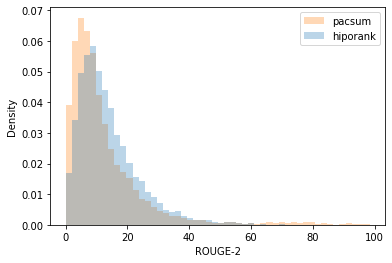

In [28]:
data = np.array([[100*h["rouge-2"]["f"],100*p["rouge-2"]["f"]] for h,p in zip(hr_score, pc_score)])
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=50)
plt.hist(data, label=["hiporank","pacsum"], **kwargs)
plt.legend(prop={'size': 10})
plt.xlabel("ROUGE-2")
plt.ylabel("Density")

/home/amr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Density')

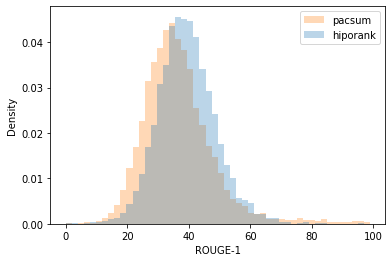

In [29]:
data = np.array([[100*h["rouge-1"]["f"],100*p["rouge-1"]["f"]] for h,p in zip(hr_score, pc_score)])
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=50)
plt.hist(data, label=["hiporank","pacsum"], **kwargs)
plt.legend(prop={'size': 10})
plt.xlabel("ROUGE-1")
plt.ylabel("Density")

/home/amr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Density')

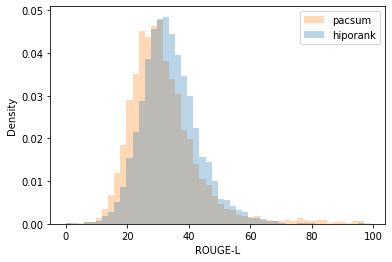

In [30]:
data = np.array([[100*h["rouge-l"]["f"],100*p["rouge-l"]["f"]] for h,p in zip(hr_score, pc_score)])
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=50)
plt.hist(data, label=["hiporank","pacsum"], **kwargs)
plt.legend(prop={'size': 10})
plt.xlabel("ROUGE-L")
plt.ylabel("Density")

In [34]:
df = pd.DataFrame()
for score in ['rouge-2']:
    df[f"hr_{score}"] = [x[score]["f"] for x in hr_score]
    df[f"ps_{score}"] = [x[score]["f"] for x in pc_score]
    df[f"delta_{score}"] = (df[f"hr_{score}"] - df[f"ps_{score}"])
    df[f"prop_delta_{score}"] = abs(df[f"delta_{score}"] - 0.003)
    df[f"ps+hr_{score}"] = [x[score]["f"] for x in m2m_score]


In [35]:
df.describe()

,hr_rouge-2,ps_rouge-2,delta_rouge-2,prop_delta_rouge-2,ps+hr_rouge-2
count,6658.000000,6658.000000,6658.000000,6658.000000,6658.000000
mean,0.136887,0.123644,0.013243,0.074252,0.265198
std,0.099476,0.131324,0.113628,0.086615,0.167232
min,0.000000,0.000000,-0.906446,0.000014,0.000000
25%,0.068627,0.046825,-0.024622,0.018755,0.147240
50%,0.113402,0.086486,0.014162,0.047343,0.257732
75%,0.180851,0.152989,0.065936,0.096974,0.359788
max,0.931034,0.984772,0.511557,0.909446,1.000000


In [37]:
# get summaries with similar scores for hiporank/pacsum to make evaluation neutral
df_same_scores = df.sort_values(by=["prop_delta_rouge-2"]).head(100)
df_same_scores

,hr_rouge-2,ps_rouge-2,delta_rouge-2,prop_delta_rouge-2,ps+hr_rouge-2
1469,0.089552,0.086538,0.003014,0.000014,0.189573
1137,0.274725,0.271739,0.002986,0.000014,0.522222
6632,0.043243,0.040201,0.003042,0.000042,0.120000
5122,0.070352,0.067308,0.003044,0.000044,0.132701
802,0.102564,0.099502,0.003062,0.000062,0.239583
...,...,...,...,...,...
5267,0.122699,0.121212,0.001487,0.001513,0.583333
4659,0.072539,0.071066,0.001473,0.001527,0.191489
2966,0.050251,0.048780,0.001471,0.001529,0.019417
2339,0.072165,0.070707,0.001458,0.001542,0.359223


In [39]:
# because the summaries are extractive, we want to remove summaries that are the same for both pacsum/hiporank
# to do this, we computed the rouge score between the two summaries
# summaries that are different from one another will have small ps/hr score
# we also drop summaries with 0 rouge scores

df_sample = df_same_scores.loc[df_same_scores["hr_rouge-2"] != 0].sort_values(by=["ps+hr_rouge-2"]).head(20)

In [40]:
df_sample["abstract"] = [pubmed_abstracts[i] for i in df_sample.index]
df_sample["hr_summary"] = [pubmed_test_hiporank[i] for i in df_sample.index]
df_sample["ps_summary"] = [pubmed_test_pacsum[i] for i in df_sample.index]


pubmed_sample_json = df_sample.to_dict(orient="index")

In [41]:
df_sample

,hr_rouge-2,ps_rouge-2,delta_rouge-2,prop_delta_rouge-2,ps+hr_rouge-2,abstract,hr_summary,ps_summary
2966,0.050251,0.048780,0.001471,0.001529,0.019417,"during a well london study , residents were ...",this article critically engages with residents...,dog poo. not only was the frequency of the com...
907,0.044693,0.043011,0.001682,0.001318,0.020305,prostate cancer ( pca ) therapy typically inv...,compound purity in all instances was greater ...,the molecular basis of the disease involves an...
4100,0.059880,0.057471,0.002409,0.000591,0.022099,\n objective . to review the recent literatur...,review of recent literature reveals significan...,"brain plasticity , the developing brain 's abi..."
4326,0.034884,0.032258,0.002626,0.000374,0.033708,in order to account for the observable univer...,numerical investigations of cosmological space...,these phenomena are described in terms of coup...
5637,0.065217,0.062827,0.002390,0.000610,0.040201,purposethe prognosis of patients with pancrea...,surgery is still considered to be the only pot...,revealing that modified histopathological work...
327,0.157303,0.153846,0.003457,0.000457,0.043478,human fingertip microflora is transferred to ...,developing forensic dna markers for human host...,microbes can negatively interfere with the pos...
3202,0.035928,0.033898,0.002030,0.000970,0.048544,laser pointers are practical and safe trainin...,most accidents are prevented by natural reflex...,anterior segments and intraocular pressures we...
6140,0.087432,0.084656,0.002776,0.000224,0.053763,fibronectin is a matrix glycoprotein which ha...,while the aforementioned studies have provided...,numerous studies have found that ecm proteins ...
1968,0.055556,0.052356,0.003200,0.000200,0.060914,with more than 60% of radical prostatectomies...,innovative techniques to incorporate real - ti...,the course of the nvbs from its origin in the ...
6159,0.178947,0.174863,0.004084,0.001084,0.071795,high sensitivity c - reactive protein ( hscrp...,the objective of this study was to analyze and...,"moreover , this biomarker predicts cv events i..."


In [42]:
len(pubmed_sample_json)

20

In [43]:
Path("./test_pubmed_samples.json").write_text(json.dumps(pubmed_sample_json, indent=4))

84612

In [46]:
pubmed_sample_json = json.loads(Path("./test_pubmed_samples.json").read_text())
prodigy_examples = []
for i,r in list(pubmed_sample_json.items()):
    i = int(i)
    for model in ["hr", "ps"]:
        if model == 'hr':
            sentences = pubmed_test_hiporank[i].split("\n")
        elif model == 'ps':
            sentences = pubmed_test_pacsum[i].split("\n")
        for j, sentence in enumerate(sentences):
            d = {
                "abstract": r['abstract'],
                "doc_index": i,
                "sentence": sentence,
                "sentence_index": j,
                "model": model,                
            }
            prodigy_examples += [d]

In [4]:
prodigy_examples[0]

{'abstract': " during a  well london study , residents were asked about their neighbourhood and its environment . above all other complaints ,  \n dog poo was mentioned as a key concern . despite low rates of infection and disease among the human population resulting from contact with canine faecal matter \n , the concerns of the public continue to rate it as a serious public health issue . \n most public health studies , therefore , seek to identify processes of transmission and disease pathology as a method of addressing the problem . \n this study approaches the issue through a contextualised analysis of residents complaints , using anthropological theory to examine the symbolic representation of  \n dog poo. analysis of the interviews shows that these specific complaints were located among less easily defined or articulated experiences of social and environmental neglect , where neighbours were estranged from one another and local authorities seen as negligent . \n this approach ha

In [5]:
prodigy_examples = [{"text": f"ABSTRACT:\n {x['abstract']}\n========================\n SENTENCE:\n{x['sentence']}",
                    "meta": dict(model=x['model'], sentence_index=x['sentence_index'], doc_index=x['doc_index'])}
                    for x in prodigy_examples]

In [6]:
prodigy_examples[0]

{'text': "ABSTRACT:\n  during a  well london study , residents were asked about their neighbourhood and its environment . above all other complaints ,  \n dog poo was mentioned as a key concern . despite low rates of infection and disease among the human population resulting from contact with canine faecal matter \n , the concerns of the public continue to rate it as a serious public health issue . \n most public health studies , therefore , seek to identify processes of transmission and disease pathology as a method of addressing the problem . \n this study approaches the issue through a contextualised analysis of residents complaints , using anthropological theory to examine the symbolic representation of  \n dog poo. analysis of the interviews shows that these specific complaints were located among less easily defined or articulated experiences of social and environmental neglect , where neighbours were estranged from one another and local authorities seen as negligent . \n this app

In [7]:
Path("./prodigy_test_pubmed_samples.jsonl").write_text("\n".join([json.dumps(j) for j in prodigy_examples]))

441802